In [1]:
import numpy as np
import nibabel as nib
import os

import matplotlib.pyplot as plt
import seaborn as sns

from pylab import rcParams

from sklearn.preprocessing import scale
import pandas as pd

from tqdm import tqdm_notebook as tqdm
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import KFold

from sklearn.metrics import mean_absolute_error as MAE

import gc

def make_age_list(files, age_df):
    age_list = []
    for file in files:
        ID = file[17:25]
        age_list.append(df.loc[df[0] == ID][1].values[0])
    return age_list

In [3]:
#reading white matter and age files
folder_wm = 'wm_data'
folder_gm = 'gm_data'


files_wm = os.listdir(folder_wm)
files_gm = os.listdir(folder_gm)

df = pd.read_csv('original_participant_data.tsv', header=None, sep='\t')
ages = make_age_list(files_wm,df)

gc.collect()
data = np.zeros((len(files_wm), 121,145,121, 2))
for sub in range(len(files_wm)):
    ID = files_wm[sub]
    img = nib.load(folder_wm + '/'+ID)
    data[sub,...,0] = img.get_data()
for sub in range(len(files_gm)):
    ID = files_wm[sub]
    
    
    #Its a dirty hack, but its a hackathon right? There is no time for smarter parsing
    ID = ID[:4] + '1' + ID[5:]

    img = nib.load(folder_gm + '/'+ID)
    data[sub,...,1] = img.get_data()

# Age distribution:

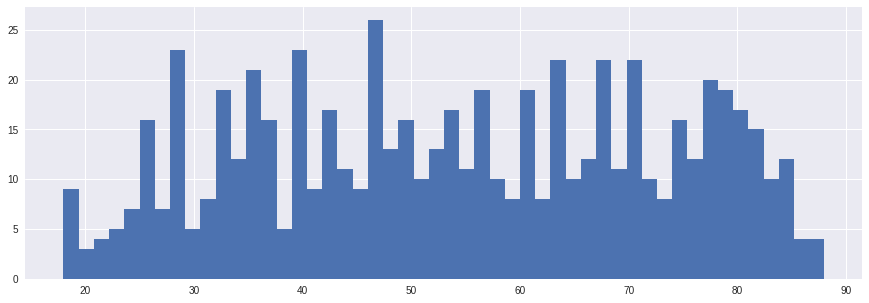

In [4]:
rcParams['figure.figsize'] = 15, 5

plt.hist(ages, 50)
plt.show()

# It looks like scans are not rotated or shifted much:

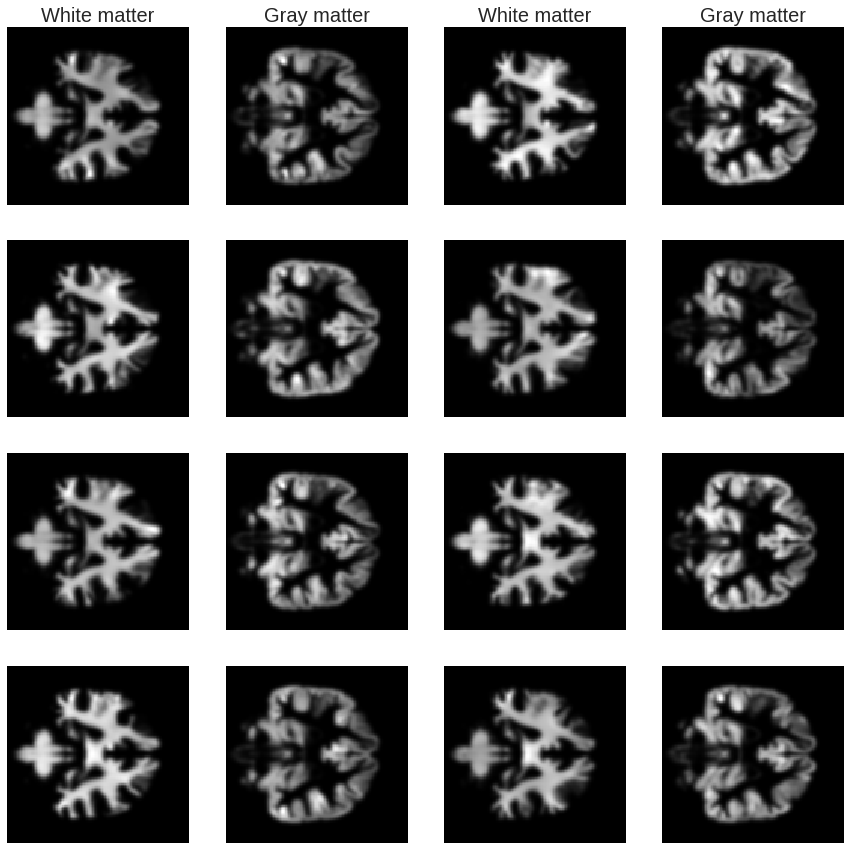

In [11]:
#plotting middle axial slice for 16 subjects
rcParams['figure.figsize'] = 15, 15

f, ax = plt.subplots(4,4)
for sub in range(8):
    sns.heatmap(data[sub,:,60,:,0], cmap = 'gray', xticklabels = False, yticklabels = False, 
                ax = ax[sub//2, (2*sub)%4], cbar = False)
    sns.heatmap(data[sub,:,60,:,1], cmap = 'gray', xticklabels = False, yticklabels = False, 
                ax = ax[sub//2, (2*sub+1)%4], cbar = False)

ax[0,0].set_title('White matter', fontsize = 20)
ax[0,1].set_title('Gray matter', fontsize = 20)
ax[0,2].set_title('White matter', fontsize = 20)
ax[0,3].set_title('Gray matter', fontsize = 20)


plt.show()

In [13]:
#averaging densities on consecutive slices
n_subjects = len(files_wm)
averaged_densities = np.zeros((n_subjects, 145, 3, 2))

for sub in range(n_subjects):
    averaged_densities[sub, :121, 0, :] = np.mean(data[sub,...],(0,1))
    averaged_densities[sub, :, 1, :] = np.mean(data[sub,...],(0,2))
    averaged_densities[sub, :121, 2, :] = np.mean(data[sub,...],(1,2))

# Data is not perfectly normalised, what can be seen by plotting average densities of consecutive slices. Also: there are two outliers.

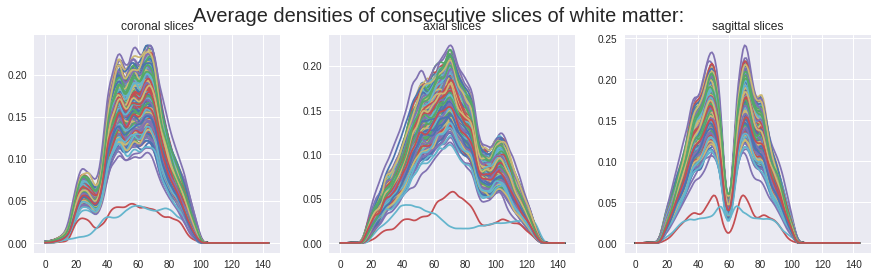

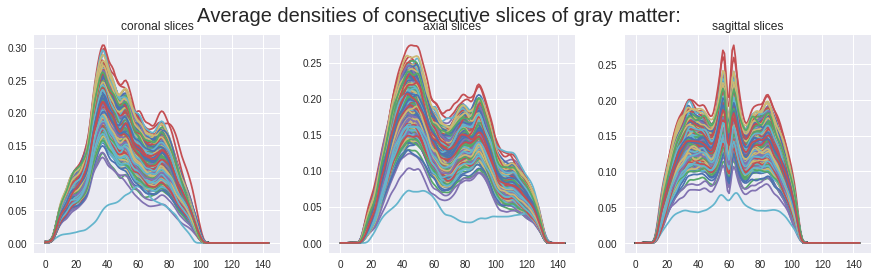

In [15]:
rcParams['figure.figsize'] = 15,4

f, ax = plt.subplots(1,3)
labels = ['coronal slices', 'axial slices', 'sagittal slices']
for i in range(3):
    ax[i].plot(averaged_densities[:,:,i,0].T)
    ax[i].set_title(labels[i])

plt.suptitle('Average densities of consecutive slices of white matter:', fontsize=20)
plt.show()

rcParams['figure.figsize'] = 15,4

f, ax = plt.subplots(1,3)
labels = ['coronal slices', 'axial slices', 'sagittal slices']
for i in range(3):
    ax[i].plot(averaged_densities[:,:,i,1].T)
    ax[i].set_title(labels[i])

plt.suptitle('Average densities of consecutive slices of gray matter:', fontsize=20)
plt.show()

# Lets check how predictive are above plots:

In [6]:
sh = averaged_densities.shape
density_features = averaged_densities.transpose([0,2,1,3]).reshape(sh[0],sh[1]*sh[2],sh[3])

In [7]:
model = Ridge(10**(-3))
n_folds = 10
predicted_ages = np.zeros(len(ages))
kf = KFold(n_folds)
parameters = np.zeros((n_folds, density_features.shape[1]))

for i_train, i_test in kf.split(density_features, ages):
    model.fit(density_features[i_train,:,0], np.array(ages)[i_train])
    predicted_ages[i_test] = model.predict(density_features[i_test,:,0])
print('White matter MAE: ', MAE(ages,predicted_ages))

for i_train, i_test in kf.split(density_features, ages):
    model.fit(density_features[i_train,:,1], np.array(ages)[i_train])
    predicted_ages[i_test] = model.predict(density_features[i_test,:,1])
print('Gray matter MAE: ', MAE(ages,predicted_ages))

White matter MAE:  8.25135593592
Gray matter MAE:  7.41946619345


# Lets use just ridge regression on central slices to fina a baseline MAE

In [50]:
features = np.zeros((645, 145*121+121*121+121*145,2))
features[:,:145*121,:] = data[:,60,...,:].reshape(645,121*145,2)
features[:,145*121:(145*121+121*121),:] = data[:,:,72,...,:].reshape(645,121*121,2)
features[:,(145*121+121*121):,:] = data[...,60,:].reshape(645,121*145,2)


wm_features = features[:,::7,0] #we downsample by odd and prime number to allow all layers and both kind of matters
gm_features = features[:,::7,1]
full_features = features[:,::13,:]
full_features = full_features.reshape(645,full_features.shape[1]*2)


model = Ridge()
n_folds = 10
predicted_ages = np.zeros(len(ages))
kf = KFold(n_folds)

for i_train, i_test in kf.split(wm_features, ages):
    model.fit(wm_features[i_train,:], np.array(ages)[i_train])
    predicted_ages[i_test] = model.predict(wm_features[i_test,:])
print('WM prediction: ',MAE(ages,predicted_ages))
for i_train, i_test in kf.split(gm_features, ages):
    model.fit(gm_features[i_train,:], np.array(ages)[i_train])
    predicted_ages[i_test] = model.predict(gm_features[i_test,:])
print('GM prediction: ',MAE(ages,predicted_ages))
for i_train, i_test in kf.split(full_features, ages):
    model.fit(full_features[i_train,:], np.array(ages)[i_train])
    predicted_ages[i_test] = model.predict(full_features[i_test,:])
print('WM+GM prediction: ',MAE(ages,predicted_ages))

WM prediction:  6.55327385026
GM prediction:  6.7818353374
WM+GM prediction:  5.92666651107


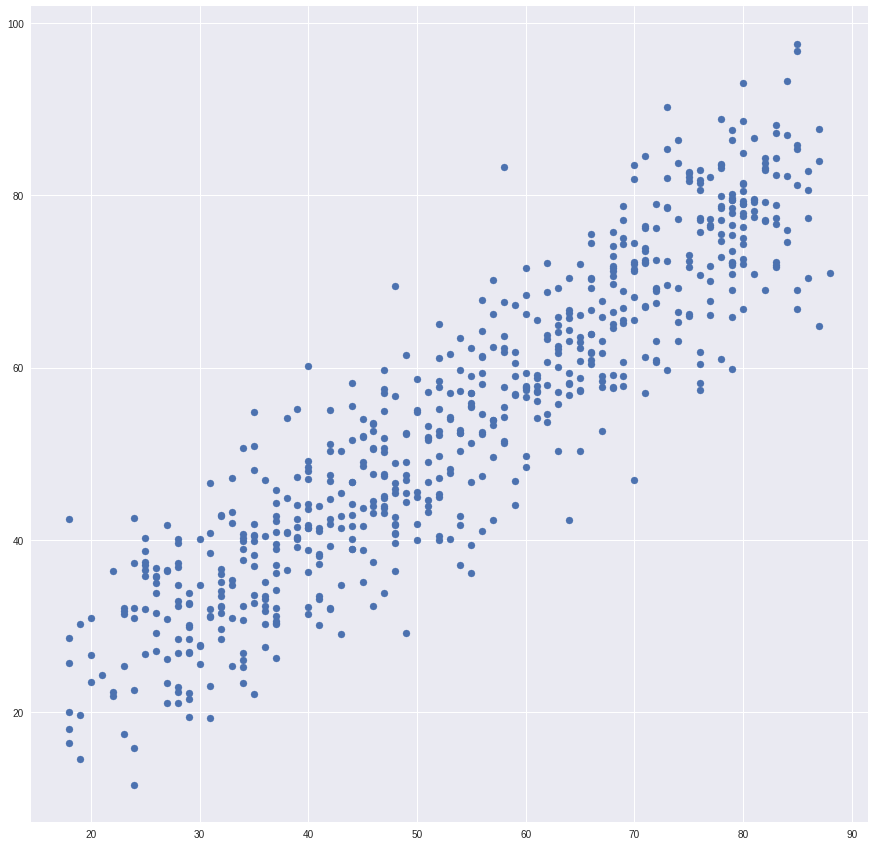

In [51]:
plt.scatter(ages, predicted_ages)
plt.show()

# Baseline MAE from ridge is roughly 5.8, now we can try to make it beter with keras